In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import math
import copy

In [2]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.models as models

In [5]:
device = torch.device("cuda")

## Image to Tensor Conversions

In [42]:
imsize = 256

def file_to_tensor(file_path):
    image = Image.open(file_path)
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def image_to_tensor(image):
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def tensor_to_image(tensor):
    img = transforms.ToPILImage()(tensor.clone().cpu().squeeze(0))
    return img

In [43]:
set_folder = "Set11"

content = file_to_tensor("UpdatedSets/"+set_folder+"/content.jpg")
style = file_to_tensor("UpdatedSets/"+set_folder+"/style.png")

In [23]:
if content.size() != style.size():
    print("Please execute Processing the Data.ipynb on the dataset")

## Choosing the optimal model

In [24]:
vgg = models.vgg19_bn(pretrained=True).features.to(device).eval()

# Setting Up the Normalisation Layer for VGG

In [10]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1,1,1)
    
    def forward(self, img):
        return (img - self.mean)/self.std

# Setting Up the Content Loss - Simple MSE Loss

In [11]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(img, self.target)
        return img

# Setting Up the Style Loss - Using Gram Matrix

In [12]:
def convert_to_gram(img):
    b, f, h, w = img.size()
    reshp_img = img.view(b*f, w*h)
    gram = torch.mm(reshp_img, reshp_img.t()).div(b*f*w*h)
    return gram

In [13]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = convert_to_gram(target).detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(convert_to_gram(img), self.target)
        return img

# Create the new model

In [25]:
content_layers = ['conv_2', 'conv_5']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_7']


def get_new_model(vgg19, content_image, style_image):
    
    global content_layers
    global style_layers
    content_modules = []
    style_modules = []

    vgg = copy.deepcopy(vgg19)
    normalisation = Normalization().to(device)
    model = nn.Sequential(normalisation)
    i = 0

    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_'+str(i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_'+str(i)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_'+str(i)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_'+str(i)

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_l = ContentLoss(target)
            model.add_module('content_layer_'+str(i), content_l)
            content_modules.append(content_l)
        
        if name in style_layers:
            target = model(style_image).detach()
            style_l = StyleLoss(target)
            model.add_module('style_layer_'+str(i), style_l)
            style_modules.append(style_l)
        
    for i in range(len(model)-1, 0, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]
    return model, content_modules, style_modules

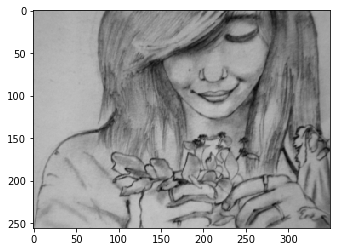

In [48]:
use_content = True
input_img = None

if use_content is True:
    # For using the content image
    input_img = tensor_to_image(content)
else:
    # For using random noise as input
    input_img = tensor_to_image(torch.randn(content.data.size(), device=device))

plt.imshow(input_img)

# Training the model

In [49]:
def style_transfer(vgg, content_img, style_img, input_img, iters=10, style_w=1000000, content_w=1):
    
    input_img = image_to_tensor(input_img)
    model, con_layers, st_layers = get_new_model(vgg, content_img, style_img)
    optimiser = torch.optim.LBFGS([input_img.requires_grad_()], lr=0.05)
    
    for i in range(iters):
        
        def closure():
            input_img.data.clamp_(0, 1)
            model(input_img)
            style_val = 0
            content_val = 0
            
            optimiser.zero_grad()

            for sc in st_layers:
                style_val += sc.loss
            for cc in con_layers:
                content_val += cc.loss

            net_loss = style_w*style_val + content_w*content_val
            net_loss.backward()
            print('Iteration {}: '.format(i+1), 'Style Loss = {:4f} '.format(style_val),
              'Content Loss = {:4f} '.format(content_val))
            return net_loss
            
        optimiser.step(closure)

    input_img.data.clamp_(0, 1)
    final_img = tensor_to_image(input_img)
    plt.imshow(final_img)
    return final_img

Iteration 1:  Style Loss = 0.000021  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000021  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000021  Content Loss = 0.000808 
Iteration 1:  Style Loss = 0.000020  Content Loss = 0.001644 
Iteration 1:  Style Loss = 0.000020  Content Loss = 0.003877 
Iteration 1:  Style Loss = 0.000019  Content Loss = 0.006407 
Iteration 1:  Style Loss = 0.000019  Content Loss = 0.008293 
Iteration 1:  Style Loss = 0.000019  Content Loss = 0.010266 
Iteration 1:  Style Loss = 0.000018  Content Loss = 0.011849 
Iteration 1:  Style Loss = 0.000018  Content Loss = 0.013409 
Iteration 1:  Style Loss = 0.000018  Content Loss = 0.014989 
Iteration 1:  Style Loss = 0.000018  Content Loss = 0.016457 
Iteration 1:  Style Loss = 0.000018  Content Loss = 0.017971 
Iteration 1:  Style Loss = 0.000017  Content Loss = 0.019530 
Iteration 1:  Style Loss = 0.000017  Content Loss = 0.021134 
Iteration 1:  Style Loss = 0.000017  Content Loss = 0.022909 
Iteratio

Iteration 7:  Style Loss = 0.000004  Content Loss = 0.164840 
Iteration 7:  Style Loss = 0.000004  Content Loss = 0.164986 
Iteration 7:  Style Loss = 0.000004  Content Loss = 0.165187 
Iteration 7:  Style Loss = 0.000004  Content Loss = 0.165434 
Iteration 7:  Style Loss = 0.000004  Content Loss = 0.165747 
Iteration 7:  Style Loss = 0.000004  Content Loss = 0.166126 
Iteration 7:  Style Loss = 0.000004  Content Loss = 0.166547 
Iteration 8:  Style Loss = 0.000004  Content Loss = 0.167041 
Iteration 8:  Style Loss = 0.000004  Content Loss = 0.167571 
Iteration 8:  Style Loss = 0.000004  Content Loss = 0.168145 
Iteration 8:  Style Loss = 0.000004  Content Loss = 0.168778 
Iteration 8:  Style Loss = 0.000004  Content Loss = 0.169502 
Iteration 8:  Style Loss = 0.000004  Content Loss = 0.170277 
Iteration 8:  Style Loss = 0.000004  Content Loss = 0.171174 
Iteration 8:  Style Loss = 0.000004  Content Loss = 0.172209 
Iteration 8:  Style Loss = 0.000004  Content Loss = 0.173323 
Iteratio

Iteration 14:  Style Loss = 0.000001  Content Loss = 0.283254 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.286447 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.289355 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.292237 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.295212 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.298193 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.301111 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.303487 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.306284 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.308914 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.311053 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.312896 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.314861 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.316482 
Iteration 14:  Style Loss = 0.000001  Content Loss = 0.318205 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.

Iteration 20:  Style Loss = 0.000001  Content Loss = 0.271833 
Iteration 20:  Style Loss = 0.000001  Content Loss = 0.271211 
Iteration 20:  Style Loss = 0.000001  Content Loss = 0.270632 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.270092 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.269511 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.268896 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.268193 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.267480 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.266705 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.265880 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.265072 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.264307 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.263592 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.262860 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.262086 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.

Iteration 27:  Style Loss = 0.000001  Content Loss = 0.303023 
Iteration 27:  Style Loss = 0.000001  Content Loss = 0.303373 
Iteration 27:  Style Loss = 0.000001  Content Loss = 0.303201 
Iteration 27:  Style Loss = 0.000001  Content Loss = 0.302688 
Iteration 27:  Style Loss = 0.000001  Content Loss = 0.301984 
Iteration 27:  Style Loss = 0.000001  Content Loss = 0.301363 
Iteration 27:  Style Loss = 0.000001  Content Loss = 0.301318 
Iteration 27:  Style Loss = 0.000001  Content Loss = 0.301620 
Iteration 27:  Style Loss = 0.000001  Content Loss = 0.301784 
Iteration 27:  Style Loss = 0.000001  Content Loss = 0.301740 
Iteration 27:  Style Loss = 0.000001  Content Loss = 0.301409 
Iteration 28:  Style Loss = 0.000001  Content Loss = 0.300985 
Iteration 28:  Style Loss = 0.000001  Content Loss = 0.300510 
Iteration 28:  Style Loss = 0.000001  Content Loss = 0.299902 
Iteration 28:  Style Loss = 0.000001  Content Loss = 0.299523 
Iteration 28:  Style Loss = 0.000001  Content Loss = 0.

Iteration 34:  Style Loss = 0.000012  Content Loss = 0.564948 
Iteration 34:  Style Loss = 0.000011  Content Loss = 0.551921 
Iteration 34:  Style Loss = 0.000011  Content Loss = 0.539403 
Iteration 34:  Style Loss = 0.000011  Content Loss = 0.527333 
Iteration 34:  Style Loss = 0.000011  Content Loss = 0.515638 
Iteration 34:  Style Loss = 0.000011  Content Loss = 0.504205 
Iteration 34:  Style Loss = 0.000011  Content Loss = 0.492828 
Iteration 34:  Style Loss = 0.000011  Content Loss = 0.481794 
Iteration 34:  Style Loss = 0.000010  Content Loss = 0.471132 
Iteration 34:  Style Loss = 0.000010  Content Loss = 0.460823 
Iteration 34:  Style Loss = 0.000010  Content Loss = 0.450914 
Iteration 34:  Style Loss = 0.000010  Content Loss = 0.441114 
Iteration 34:  Style Loss = 0.000010  Content Loss = 0.431535 
Iteration 34:  Style Loss = 0.000010  Content Loss = 0.422409 
Iteration 34:  Style Loss = 0.000010  Content Loss = 0.413585 
Iteration 34:  Style Loss = 0.000010  Content Loss = 0.

Iteration 40:  Style Loss = 0.000001  Content Loss = 0.249023 
Iteration 40:  Style Loss = 0.000001  Content Loss = 0.248504 
Iteration 40:  Style Loss = 0.000001  Content Loss = 0.247981 
Iteration 40:  Style Loss = 0.000001  Content Loss = 0.247491 
Iteration 40:  Style Loss = 0.000001  Content Loss = 0.247018 
Iteration 40:  Style Loss = 0.000001  Content Loss = 0.246564 
Iteration 40:  Style Loss = 0.000001  Content Loss = 0.246114 
Iteration 41:  Style Loss = 0.000001  Content Loss = 0.245672 
Iteration 41:  Style Loss = 0.000001  Content Loss = 0.245242 
Iteration 41:  Style Loss = 0.000001  Content Loss = 0.244832 
Iteration 41:  Style Loss = 0.000001  Content Loss = 0.244430 
Iteration 41:  Style Loss = 0.000001  Content Loss = 0.244037 
Iteration 41:  Style Loss = 0.000001  Content Loss = 0.243669 
Iteration 41:  Style Loss = 0.000001  Content Loss = 0.243313 
Iteration 41:  Style Loss = 0.000001  Content Loss = 0.242961 
Iteration 41:  Style Loss = 0.000001  Content Loss = 0.

Iteration 47:  Style Loss = 0.000001  Content Loss = 0.191318 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.191210 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.191113 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.191021 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.190937 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.190848 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.190747 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.190649 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.190550 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.190461 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.190358 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.190267 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.190178 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.190102 
Iteration 47:  Style Loss = 0.000001  Content Loss = 0.190020 
Iteration 48:  Style Loss = 0.000001  Content Loss = 0.

Iteration 53:  Style Loss = 0.000001  Content Loss = 0.192286 
Iteration 53:  Style Loss = 0.000001  Content Loss = 0.192371 
Iteration 53:  Style Loss = 0.000001  Content Loss = 0.192406 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.192365 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.192345 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.192310 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.192292 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.192219 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.192117 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.192017 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.191890 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.191769 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.191644 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.191550 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.191525 
Iteration 54:  Style Loss = 0.000001  Content Loss = 0.

Iteration 60:  Style Loss = 0.000001  Content Loss = 0.209793 
Iteration 60:  Style Loss = 0.000001  Content Loss = 0.209849 
Iteration 60:  Style Loss = 0.000001  Content Loss = 0.210001 
Iteration 60:  Style Loss = 0.000001  Content Loss = 0.210273 
Iteration 60:  Style Loss = 0.000001  Content Loss = 0.210509 
Iteration 60:  Style Loss = 0.000001  Content Loss = 0.210970 
Iteration 60:  Style Loss = 0.000001  Content Loss = 0.211182 
Iteration 60:  Style Loss = 0.000001  Content Loss = 0.211340 
Iteration 60:  Style Loss = 0.000001  Content Loss = 0.211494 
Iteration 60:  Style Loss = 0.000001  Content Loss = 0.211938 
Iteration 60:  Style Loss = 0.000001  Content Loss = 0.212398 
Iteration 61:  Style Loss = 0.000001  Content Loss = 0.212684 
Iteration 61:  Style Loss = 0.000001  Content Loss = 0.213040 
Iteration 61:  Style Loss = 0.000001  Content Loss = 0.213566 
Iteration 61:  Style Loss = 0.000001  Content Loss = 0.214167 
Iteration 61:  Style Loss = 0.000001  Content Loss = 0.

Iteration 67:  Style Loss = 0.000004  Content Loss = 0.394970 
Iteration 67:  Style Loss = 0.000005  Content Loss = 0.405751 
Iteration 67:  Style Loss = 0.000005  Content Loss = 0.406125 
Iteration 67:  Style Loss = 0.000005  Content Loss = 0.409666 
Iteration 67:  Style Loss = 0.000005  Content Loss = 0.409193 
Iteration 67:  Style Loss = 0.000005  Content Loss = 0.408621 
Iteration 67:  Style Loss = 0.000005  Content Loss = 0.407594 
Iteration 67:  Style Loss = 0.000005  Content Loss = 0.406767 
Iteration 67:  Style Loss = 0.000005  Content Loss = 0.407358 
Iteration 67:  Style Loss = 0.000004  Content Loss = 0.406583 
Iteration 67:  Style Loss = 0.000004  Content Loss = 0.407630 
Iteration 67:  Style Loss = 0.000004  Content Loss = 0.406493 
Iteration 67:  Style Loss = 0.000004  Content Loss = 0.406022 
Iteration 67:  Style Loss = 0.000004  Content Loss = 0.403746 
Iteration 67:  Style Loss = 0.000004  Content Loss = 0.402328 
Iteration 67:  Style Loss = 0.000004  Content Loss = 0.

Iteration 73:  Style Loss = 0.000014  Content Loss = 0.316449 
Iteration 73:  Style Loss = 0.000014  Content Loss = 0.315459 
Iteration 73:  Style Loss = 0.000014  Content Loss = 0.314483 
Iteration 73:  Style Loss = 0.000014  Content Loss = 0.313527 
Iteration 73:  Style Loss = 0.000014  Content Loss = 0.312594 
Iteration 73:  Style Loss = 0.000014  Content Loss = 0.311691 
Iteration 73:  Style Loss = 0.000014  Content Loss = 0.310798 
Iteration 74:  Style Loss = 0.000014  Content Loss = 0.309952 
Iteration 74:  Style Loss = 0.000014  Content Loss = 0.309114 
Iteration 74:  Style Loss = 0.000013  Content Loss = 0.308241 
Iteration 74:  Style Loss = 0.000013  Content Loss = 0.307397 
Iteration 74:  Style Loss = 0.000013  Content Loss = 0.306587 
Iteration 74:  Style Loss = 0.000013  Content Loss = 0.305770 
Iteration 74:  Style Loss = 0.000013  Content Loss = 0.304993 
Iteration 74:  Style Loss = 0.000013  Content Loss = 0.304223 
Iteration 74:  Style Loss = 0.000013  Content Loss = 0.

Iteration 80:  Style Loss = 0.000004  Content Loss = 0.257688 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.257837 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.257937 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.258003 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.258023 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.258010 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.257946 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.257818 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.257647 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.257439 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.257210 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.256944 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.256650 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.256343 
Iteration 80:  Style Loss = 0.000004  Content Loss = 0.255975 
Iteration 81:  Style Loss = 0.000004  Content Loss = 0.

Iteration 86:  Style Loss = 0.000002  Content Loss = 0.218085 
Iteration 86:  Style Loss = 0.000002  Content Loss = 0.218123 
Iteration 86:  Style Loss = 0.000002  Content Loss = 0.218182 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.218266 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.218361 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.218455 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.218544 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.218665 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.218777 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.218905 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.219051 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.219238 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.219434 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.219625 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.219843 
Iteration 87:  Style Loss = 0.000002  Content Loss = 0.

Iteration 93:  Style Loss = 0.000001  Content Loss = 0.337547 
Iteration 93:  Style Loss = 0.000001  Content Loss = 0.336586 
Iteration 93:  Style Loss = 0.000001  Content Loss = 0.335765 
Iteration 93:  Style Loss = 0.000001  Content Loss = 0.335082 
Iteration 93:  Style Loss = 0.000001  Content Loss = 0.334501 
Iteration 93:  Style Loss = 0.000001  Content Loss = 0.333955 
Iteration 93:  Style Loss = 0.000001  Content Loss = 0.333289 
Iteration 93:  Style Loss = 0.000001  Content Loss = 0.332613 
Iteration 93:  Style Loss = 0.000001  Content Loss = 0.331878 
Iteration 93:  Style Loss = 0.000001  Content Loss = 0.331165 
Iteration 93:  Style Loss = 0.000001  Content Loss = 0.330325 
Iteration 94:  Style Loss = 0.000001  Content Loss = 0.329372 
Iteration 94:  Style Loss = 0.000001  Content Loss = 0.328337 
Iteration 94:  Style Loss = 0.000001  Content Loss = 0.327278 
Iteration 94:  Style Loss = 0.000001  Content Loss = 0.326148 
Iteration 94:  Style Loss = 0.000001  Content Loss = 0.

Iteration 100:  Style Loss = 0.000001  Content Loss = 0.241355 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.241349 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.241343 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.241364 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.241480 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.241572 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.241687 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.241887 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.242078 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.242251 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.242377 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.242481 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.242549 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.242578 
Iteration 100:  Style Loss = 0.000001  Content Loss = 0.242649 
Iteration 100:  Style Loss = 0.000001  C

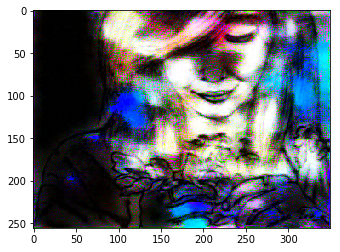

In [50]:
output = style_transfer(vgg, content, style, input_img, iters=100, style_w=5000000, content_w=100)
output.save("UpdatedSets/"+set_folder+"/output.png")